## Standard Dependencies

In [3]:
# standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# tensorflow dependencies
#python -m pip install tensorflow_io==0.23.1
# conda install -c apple tensorflow-deps  
# https://developer.apple.com/metal/tensorflow-plugin/
# https://caffeinedev.medium.com/how-to-install-tensorflow-on-m1-mac-8e9b91d93706
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
# avoid GPU memory consumption
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(gpus))


Num GPUs Available:  1


## Prep dataset

In [6]:
POS_PATH = "data/positive"
NEG_PATH = "data/negative"
ANC_PATH = "data/anchor"

In [ ]:
# populate the negative class - only run once


# for directory in os.listdir('lfw'):
#     if directory == ".DS_Store":
#         continue
#     for file in os.listdir(os.path.join('lfw', directory)):
#         ex_path = os.path.join('lfw' ,directory, file)
#         new_path = os.path.join(NEG_PATH,file)
#         os.replace(ex_path, new_path)

##### collect positive and anchor classes

In [7]:
# import UUID library to generate unique names for images
import uuid # universally unique identifier

'/Users/o_sho/Documents/Coding/Personal/Facial Recognition'

In [66]:
# collect positive and anchor classes using cv2

# establish connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # crop img to 250x250
    y = 500
    frame = frame[:, y:y+1080, :]
    frame = cv2.resize(frame, (250,250), interpolation = cv2.INTER_AREA)
    
    # collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # save image with unique path
        imgname = os.path.join(ANC_PATH, str(uuid.uuid1()) + ".jpg")
        print(imgname)
        cv2.imwrite(imgname, frame)
        
    # collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # save image with unique path
        imgname = os.path.join(POS_PATH, str(uuid.uuid1()) + ".jpg")
        cv2.imwrite(imgname, frame)
    
    # display the resulting frame
    cv2.imshow ('Image Collection', frame)

    # to quit press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
cap.release()
# Destroy all the windows
cv2.destroyAllWindows()
for i in range(2):
    cv2.waitKey(1)
    

data/anchor/e01e148e-7518-11ed-8612-5efb4bc8c78d.jpg
data/anchor/e0526fb8-7518-11ed-8612-5efb4bc8c78d.jpg


notes:
- maybe get closer to camera, face gets too distorted bc its far

## Load Data into Tensorflow

In [28]:
anchor = tf.data.Dataset.list_files(ANC_PATH + "/*.jpg").take(500)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(500)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(500)

### preprocessing

In [29]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img/255
    return img

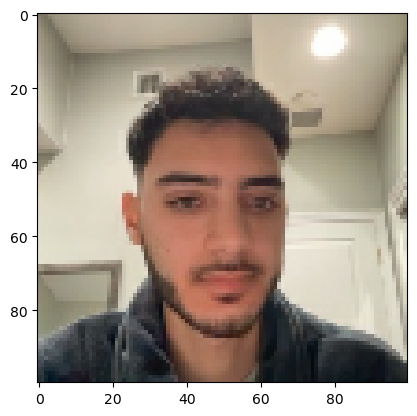

In [30]:
img = preprocess('data/anchor/0bbd7600-6ada-11ed-88c5-5efb4bc8c78c.jpg')
plt.imshow(img)

# ! image is a bit low quality

### labeled dataset

In [12]:
#(anchor, positive) -> 1, 1, 1 ...
#(anchor, negative) -> 0, 0, 0 ...

In [31]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [33]:
example = data.as_numpy_iterator().next()
example

(b'data/anchor/ef0233d8-6ada-11ed-88c5-5efb4bc8c78c.jpg',
 b'data/positive/d6cbd36a-7510-11ed-8612-5efb4bc8c78d.jpg',
 1.0)

### test and train partition

In [34]:
def preprocess_tuple(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [35]:
# preprocess the data and shuffle
data = data.map(preprocess_tuple)
data = data.cache()
data = data.shuffle(1024)

In [36]:
# train data
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# test data
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

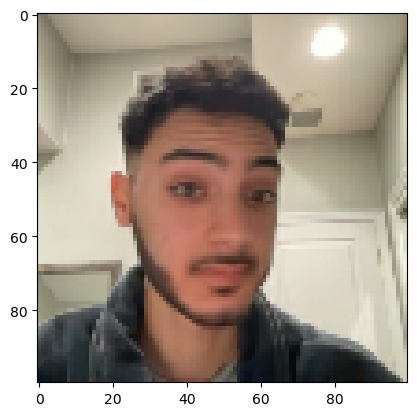

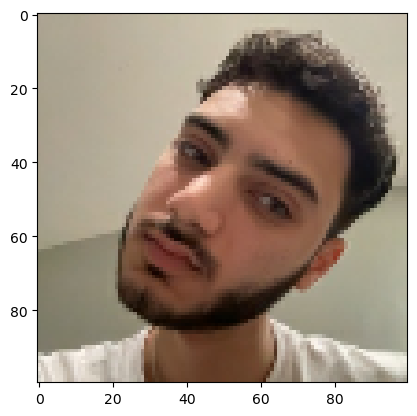

In [46]:
tr_iterator = train_data.as_numpy_iterator()
plt.imshow(tr_iterator.next()[0][0])
plt.show()
tr_iterator = test_data.as_numpy_iterator()
plt.imshow(tr_iterator.next()[0][0])
plt.show()

## Model Engineering

In [48]:
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_img')
    
    #first block
    conv1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(conv1)
    
    #second block
    conv2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(conv2)
    
    #third block
    conv3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(conv3)
    
    #final embedding
    conv4 = Conv2D(256, (4,4), activation='relu')(m3)
    flat1 = Flatten()(conv4)
    d1 = Dense(4096, activation='sigmoid')(flat1)
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding' )

embedding = make_embedding()

In [49]:
# creating the distance layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    # performing similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [50]:
def make_siamese_model():
    
    # inp = anchor, validation = positive or negative
    input_img = Input(shape=(100,100,3), name='input_img')
    validation_img = Input(shape=(100,100,3), name='validation_img')
    
    # combine embeddings in a simaese layer
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding(input_img), embedding(validation_img))
    
    # classification layer
    classifier = Dense(1, activation='sigmoid', name='classifier')(distances)
    
    return Model(inputs=[input_img, validation_img], outputs=[classifier], name='siamese_model')

siamese_model = make_siamese_model()

## Training

In [51]:
## loss function
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

## optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [52]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefic = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(siamese_model=siamese_model, opt=opt)

### train step function

In [53]:
@tf.function
def train_step(batch):
    
    # record the operations done during the forward pass
    with tf.GradientTape() as tape:
        
        # unlood input and validation images and labels
        X = batch[:2]
        y = batch[2]
        
        # forward pass
        y_pred = siamese_model(X, training=True)
                
        # loss calculation
        loss = binary_cross_loss(y, y_pred)
        
    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # calculate updated weights then apply to model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

### training loop

In [54]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        
        print(f'Epoch {epoch} of {EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx+1, values=[('loss', loss)])
        
        if epoch % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefic)

## Train Model

In [55]:
EPOCHS = 50

In [56]:
train(train_data, EPOCHS)

Epoch 1 of 50


2022-12-05 22:00:16.347540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/44 [============================>.] - ETA: 1s - loss: 0.3791

2022-12-05 22:01:07.949245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 53s 1s/step - loss: 0.3748
Epoch 2 of 50
44/44 [==============================] - 50s 1s/step - loss: 0.0864
Epoch 3 of 50
44/44 [==============================] - 51s 1s/step - loss: 0.0638
Epoch 4 of 50
44/44 [==============================] - 54s 1s/step - loss: 0.0540
Epoch 5 of 50
44/44 [==============================] - 51s 1s/step - loss: 0.0378
Epoch 6 of 50
44/44 [==============================] - 52s 1s/step - loss: 0.0271
Epoch 7 of 50
44/44 [==============================] - 50s 1s/step - loss: 0.0172
Epoch 8 of 50
44/44 [==============================] - 51s 1s/step - loss: 0.0775
Epoch 9 of 50
44/44 [==============================] - 50s 1s/step - loss: 0.0119
Epoch 10 of 50
44/44 [==============================] - 50s 1s/step - loss: 0.0170
Epoch 11 of 50
44/44 [==============================] - 52s 1s/step - loss: 0.0082
Epoch 12 of 50
44/44 [==============================] - 50s 1s/step - loss: 0.0095
Epoch 13 of 50
44/44 [=====

KeyboardInterrupt: 

## Evaluation

In [57]:
from tensorflow.keras.metrics import Precision, Recall

In [59]:
# make predictions
y_pred = np.empty((1,1))
y_true = np.empty((1))
for test_input, test_val, sample_true in test_data.as_numpy_iterator():
    temp = siamese_model.predict([test_input, test_val])
    y_pred = np.concatenate((y_pred, temp))
    y_true = np.concatenate((y_true, sample_true))
y_pred = y_pred[1:]
y_true = y_true[1:]

1/1 [==============================] - 0s 316ms/step


2022-12-05 22:30:04.399697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 83ms/step


In [63]:
# Calculate metrics

# precision
p = Precision()
p.update_state(y_true, y_pred)
print('Precision: ', p.result().numpy())

# recall
r = Recall()
r.update_state(y_true, y_pred)
print('Recall: ', r.result().numpy())


Precision:  1.0
Recall:  1.0


## Manual testing

In [81]:
input_img_name = "input_image.jpg"
verification_folder = "verification_data"

In [90]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in [f for f in os.listdir(verification_folder) if not f.startswith('.')]:
        input_img = preprocess(input_img_name)
        validation_img = preprocess(os.path.join(verification_folder, image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)), verbose=0)
        results.append(result)
        
    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(verification_folder))
    verified = verification > verification_threshold 
    
    return results, verified

In [100]:
results, verified = verify(loaded_model, 0.5, 0.7)
print(verified)

2022-12-06 21:25:48.753389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


True


In [101]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # crop img to 250x250
    y = 500
    frame = frame[:, y:y+1080, :]
    

    if cv2.waitKey(1) & 0xFF == ord('v'):
        cv2.imwrite(input_img_name, frame)
        #verify
        results, verified = verify(siamese_model, 0.5, 0.7)
        print(verified)
    
    # display the resulting frame
    cv2.imshow ('Image Collection', frame)

    # to quit press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
cap.release()
# Destroy all the windows
cv2.destroyAllWindows()
for i in range(2):
    cv2.waitKey(1)
    

True
True
True


### save model

In [99]:
# save model
# siamese_model.save('siamese_model.h5')

# how to reload:
loaded_model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.keras.losses.BinaryCrossentropy})
# model.predict([test_input, test_val])
